Civilian died in fire! Score: -530
Civilian died in fire! Score: -630


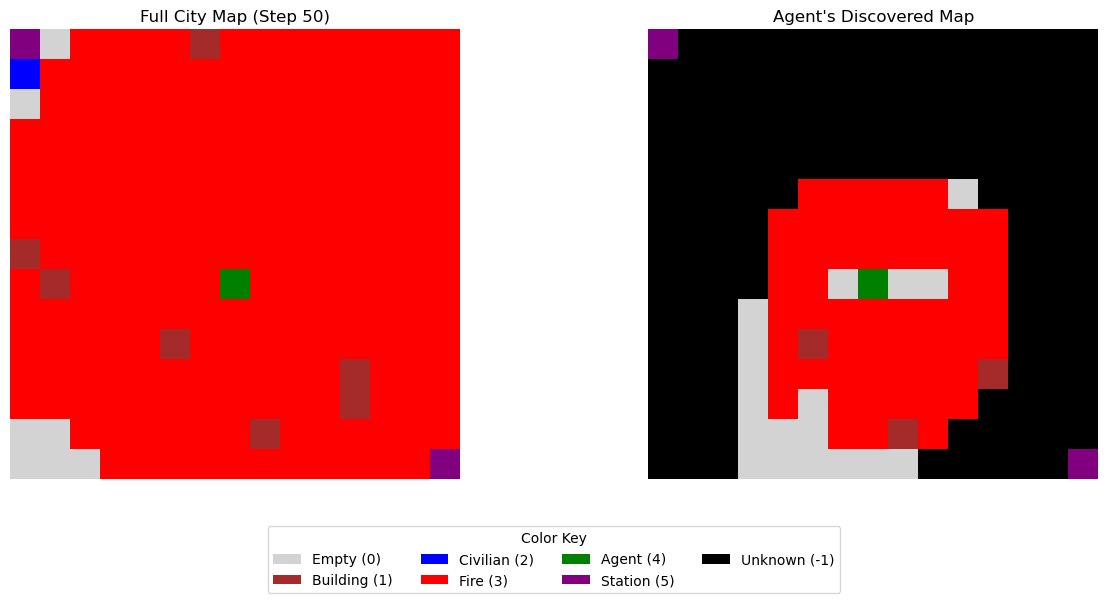

Game Over! Final Score: -630
Fires extinguished: 7
Civilians rescued: 0/8


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
import time

# Constants
GRID_SIZE = 15
NUM_BUILDINGS = 7
NUM_CIVILIANS = 8
NUM_FIRES = 5
MAX_STEPS = 50
SENSOR_RANGE = 2  # For 5x5 sensor area centered on agent

# Cell types
EMPTY = 0
BUILDING = 1
CIVILIAN = 2
FIRE = 3
AGENT = 4
STATION = 5

# Custom color mapping
COLORS = {
    EMPTY: "lightgray",  # 0
    BUILDING: "brown",   # 1
    CIVILIAN: "blue",    # 2
    FIRE: "red",         # 3
    AGENT: "green",      # 4
    STATION: "purple"    # 5
}
DISCOVERED_COLORS = COLORS.copy()
DISCOVERED_COLORS[-1] = "black"  # Unknown for agent's map

# Create custom colormaps
FULL_CMAP = ListedColormap([COLORS[i] for i in range(6)])  # 0 to 5
DISCOVERED_CMAP = ListedColormap([DISCOVERED_COLORS[i] for i in sorted(DISCOVERED_COLORS.keys())])  # -1 to 5

# Legend labels
COLOR_LEGEND = {
    "Empty (0)": COLORS[EMPTY],
    "Building (1)": COLORS[BUILDING],
    "Civilian (2)": COLORS[CIVILIAN],
    "Fire (3)": COLORS[FIRE],
    "Agent (4)": COLORS[AGENT],
    "Station (5)": COLORS[STATION],
    "Unknown (-1)": DISCOVERED_COLORS[-1]
}

class Environment:
    def __init__(self):
        self.grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
        self.civilians_rescued = 0
        self.fires_extinguished = 0
        self.score = 0
        self.steps = 0
        self.setup_environment()

    def setup_environment(self):
        self.grid[0, 0] = STATION
        self.grid[14, 14] = STATION
        for _ in range(NUM_BUILDINGS):
            self.place_random_entity(BUILDING)
        for _ in range(NUM_CIVILIANS):
            self.place_random_entity(CIVILIAN)
        for _ in range(NUM_FIRES):
            self.place_random_entity(FIRE)

    def place_random_entity(self, entity):
        while True:
            x, y = random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1)
            if self.grid[x, y] == EMPTY:
                self.grid[x, y] = entity
                break

    def spread_fire(self):
        fire_positions = list(zip(*np.where(self.grid == FIRE)))
        if not fire_positions:
            return
        for x, y in fire_positions[:]:
            directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
            random.shuffle(directions)
            for dx, dy in directions:
                new_x, new_y = x + dx, y + dy
                if (0 <= new_x < GRID_SIZE and 0 <= new_y < GRID_SIZE and 
                    self.grid[new_x, new_y] not in [FIRE, BUILDING, STATION, AGENT]):
                    if self.grid[new_x, new_y] == CIVILIAN:
                        self.score -= 100
                        print(f"Civilian died in fire! Score: {self.score}")
                    self.grid[new_x, new_y] = FIRE
                    break

    def get_grid(self):
        return self.grid

    def update_cell(self, x, y, value):
        self.grid[x, y] = value

    def increment_step(self):
        self.steps += 1

    def is_game_over(self):
        return self.steps >= MAX_STEPS or (self.fires_extinguished == NUM_FIRES and self.civilians_rescued == NUM_CIVILIANS)

    def apply_action(self, x, y, action):
        cell = self.grid[x, y]
        if action == "extinguish" and cell == FIRE:
            self.update_cell(x, y, EMPTY)
            self.fires_extinguished += 1
            self.score += 10
            print(f"Fire extinguished! Score: {self.score}")
            return True
        elif action == "rescue" and cell == CIVILIAN:
            self.update_cell(x, y, EMPTY)
            return True
        elif action == "drop" and cell == STATION:
            self.civilians_rescued += 1
            self.score += 50
            print(f"Civilian rescued! Score: {self.score}")
            return True
        return False

class Agent:
    def __init__(self, environment):
        self.env = environment
        self.pos = None
        self.discovered_map = np.full((GRID_SIZE, GRID_SIZE), -1)
        self.carrying_civilian = False  # Agent can carry only 1 civilian at a time
        self.place_agent()
        self.update_discovered_map()

    def place_agent(self):
        while True:
            x, y = random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1)
            if self.env.get_grid()[x, y] == EMPTY:
                self.env.update_cell(x, y, AGENT)
                self.pos = [x, y]
                break
        self.discovered_map[0, 0] = STATION
        self.discovered_map[14, 14] = STATION

    def update_discovered_map(self):
        x, y = self.pos
        for i in range(max(0, x - SENSOR_RANGE), min(GRID_SIZE, x + SENSOR_RANGE + 1)):
            for j in range(max(0, y - SENSOR_RANGE), min(GRID_SIZE, y + SENSOR_RANGE + 1)):
                self.discovered_map[i, j] = self.env.get_grid()[i, j]

    def move(self):
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        dx, dy = random.choice(directions)
        new_x = self.pos[0] + dx
        new_y = self.pos[1] + dy
        if (0 <= new_x < GRID_SIZE and 0 <= new_y < GRID_SIZE and 
            (self.discovered_map[new_x, new_y] == -1 or self.discovered_map[new_x, new_y] != BUILDING)):
            self.env.update_cell(self.pos[0], self.pos[1], EMPTY)
            self.pos = [new_x, new_y]
            self.handle_interaction()
            self.env.update_cell(new_x, new_y, AGENT)
            self.update_discovered_map()

    def handle_interaction(self):
        x, y = self.pos
        observed_cell = self.discovered_map[x, y]
        if observed_cell == FIRE and random.choice([True, False]):
            success = self.env.apply_action(x, y, "extinguish")
            if success:
                self.discovered_map[x, y] = EMPTY
        elif observed_cell == CIVILIAN and not self.carrying_civilian and random.choice([True, False]):
            success = self.env.apply_action(x, y, "rescue")
            if success:
                self.carrying_civilian = True  # Agent now carries 1 civilian
                self.discovered_map[x, y] = EMPTY
                print(f"Civilian picked up! Score: {self.env.score}")
        elif observed_cell == STATION and self.carrying_civilian:
            success = self.env.apply_action(x, y, "drop")
            if success:
                self.carrying_civilian = False  # Civilian dropped, agent can carry another

def display_maps(env, agent):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Full map
    ax1.imshow(env.get_grid(), cmap=FULL_CMAP, interpolation='nearest', vmin=0, vmax=5)
    ax1.set_title(f"Full City Map (Step {env.steps})")
    ax1.axis('off')

    # Discovered map
    discovered_display = agent.discovered_map
    ax2.imshow(discovered_display, cmap=DISCOVERED_CMAP, interpolation='nearest', vmin=-1, vmax=5)
    ax2.set_title("Agent's Discovered Map")
    ax2.axis('off')

    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=label) for label, color in COLOR_LEGEND.items()]
    fig.legend(handles=legend_elements, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.05), title="Color Key")
    
    plt.tight_layout()
    plt.show()

def run_simulation():
    env = Environment()
    agent = Agent(env)
    
    while not env.is_game_over():
        clear_output(wait=True)
        agent.move()
        env.increment_step()
        
        if env.steps % 5 == 0:
            env.spread_fire()
        
        display_maps(env, agent)
        time.sleep(0.5)
        
        if env.fires_extinguished == NUM_FIRES and env.civilians_rescued == NUM_CIVILIANS:
            print(f"Success! All fires extinguished and civilians rescued in {env.steps} steps.")
            break
    
    if env.steps >= MAX_STEPS:
        print(f"Game Over! Final Score: {env.score}")
        print(f"Fires extinguished: {env.fires_extinguished}")
        print(f"Civilians rescued: {env.civilians_rescued}/{NUM_CIVILIANS}")

# Run the simulation
run_simulation()